# cs236605 - Final Project

By:
Vadim Grainer & Noam Keidar

## KNN Demonstration 

In [177]:
import sklearn as sk
import matplotlib.pyplot as plt
import torchvision.transforms as tvtf
from ECG_multi_lead_dataloader import *
import transforms as tf
import torchvision
import torch
import knn_classifier as knn
import os

In [4]:
# Define the transforms that should be applied to each ECG record before returning it
tf_ds = tvtf.Compose([
    tf.ECG_tuple_transform(-1) # Reshape to 1D Tensor
])

In [ ]:
root_dir = r'/home/noamkeidar/ML/db/'

ECG_test = ECG_Multilead_Dataset(root_dir=root_dir, transform=tf_ds) # For KNN demo

In [ ]:
# Define how much data to load (only use a subset for speed)
num_train = 35000
num_test = 1000
batch_size = 10000

# Training dataset & loader
ds_train = tf.SubsetDataset(ECG_test, num_train)  #(train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=False)

# Test dataset & loader
ds_test = tf.SubsetDataset(ECG_test, num_test, offset=num_train)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)

# Get all test data to predict in one go
test_iter = iter(dl_test)
x_test, y_test = test_iter.next()

In [ ]:
knn_classifier = knn.KNNClassifier(k=10)
knn_classifier.train(dl_train)
y_pred = knn_classifier.predict(x_test)

# Calculate accuracy
accuracy = knn.accuracy(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

## Digitized 12 Lead ECG classification

This part is intended to be a banchmark for the prefoarmance of the two ECG image classification paradigms. We assume that our knowladge that the real information in the ECG images is contained only in the signal and not the background will allow easier convergence of the model and better performance.

Clean up the environment from the previous exmple to free the memory (if necessary):

In [ ]:
%reset

In [ ]:
import torch
torch.cuda.empty_cache()

### Imports and loadings

Imports and preperations, change root_dir here to the directory of the data pickles

In [179]:
import torch
import models
import transforms as tf
import matplotlib.pyplot as plt
from ECG_multi_lead_dataloader import *

##### Change root direrctory here #####
root_dir = r'/home/noamkeidar/ML/db/'

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


Load the database (might take some minutes)

In [180]:
ds = ECG_Multilead_Dataset(root_dir=root_dir)

Uploading new format


Prepare the dataloaders

In [181]:
# Define how much data to load (only use a subset for speed)

# for real training:
num_train = 35000
# for small set overfit experiment: 
#num_train = 3500
num_test = 5000
batch_size = 512

# Training dataset & loader
ds_train = tf.SubsetDataset(ds, num_train)  #(train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train,batch_size= batch_size,shuffle=True)

# Test dataset & loader
ds_test = tf.SubsetDataset(ds, num_test, offset= num_train)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)

Let's see what did we load:

In [182]:
x, y = iter(dl_train).next()
x1, x2 = x

print('Long lead data of shape: ', x2.shape)
print('Short lead data of shape: ', x1.shape)
print('Labels of shape: ', y.shape)

Long lead data of shape:  torch.Size([512, 1, 5000])
Short lead data of shape:  torch.Size([512, 12, 1250])
Labels of shape:  torch.Size([512])


### Model creation

Use this box to determine the archetecture of the digitized ECG classifing model. Note that the input data is tuples structured $(x_1,x_2)$, on which $x_1$ is a 12 on $N$ matrix containing digitized signals of short 12 lead ECG and $x_2$ is a 1 on $4\cdot N$ matrix containing the long lead. Both inputs enter the model through 1d CNNs and combined to a single set of features before finally being cassified by a simple feedforward NN. 

In [183]:
### CNNs structure: 

# num of channels and kernel length in each layer of each branch, note that list lengths must correspond 
short_hidden_channels = [16, 32, 64, 128, 256, 512]
long_hidden_channels  = [4, 8, 16, 32, 64, 128, 256, 512]
short_kernel_lengths = [5]*6
long_kernel_lengths = [5]*8

# which tricks to use: dropout, stride, batch normalization and dilation 
short_dropout = 0.5
long_dropout = 0.5
short_stride = 2
long_stride = 2
short_dilation = 1
long_dilation = 1
short_batch_norm = True
long_batch_norm = True

# enter input length here
short_input_length = 1250
long_input_length = 5000

### FC net structure:

# num of hidden units in every FC layer
fc_hidden_dims = [128]

# num of output classess 
num_of_classes = 2

build the model:

In [184]:
model = models.Ecg12LeadNet(short_hidden_channels, long_hidden_channels,
                 short_kernel_lengths, long_kernel_lengths,
                 fc_hidden_dims,
                 short_dropout, long_dropout,
                 short_stride, long_stride,
                 short_dilation, long_dilation,
                 short_batch_norm, long_batch_norm,
                 short_input_length, long_input_length,
                 num_of_classes).to(device)

print(model)

Ecg12LeadNet(
  (short_cnn): ConvNet1d(
    (cnn): Sequential(
      (0): Conv1d(12, 16, kernel_size=(5,), stride=(2,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5)
      (3): ReLU()
      (4): Conv1d(16, 32, kernel_size=(5,), stride=(2,))
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.5)
      (7): ReLU()
      (8): Conv1d(32, 64, kernel_size=(5,), stride=(2,))
      (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.5)
      (11): ReLU()
      (12): Conv1d(64, 128, kernel_size=(5,), stride=(2,))
      (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Dropout(p=0.5)
      (15): ReLU()
      (16): Conv1d(128, 256, kernel_size=(5,), stride=(2,))
      (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1

Try the model on a single batch to make sure the dimentions fit:

In [185]:
x_try = (x1.to(device, dtype=torch.float), x2.to(device, dtype=torch.float))
y_pred = model(x_try)
print('Output batch size is:', y_pred.shape[0], ', and number of class scores:', y_pred.shape[1],'\n')

num_correct = torch.sum((y_pred > 0).flatten() == (y.to(device, dtype=torch.long)==1))
print(100*num_correct.item()/len(y), '% Accurecy... maybe we should consider training the model')

Output batch size is: 512 , and number of class scores: 1 

78.90625 % Accurecy... maybe we should consider training the model


### Let the game begin - Training

This training section is based on the course abstruct Trainer class from HW 3. We have implemented a custom class for our model inhereting from Trainer.

In [188]:
import torch.nn as nn
import torch.optim as optim
from training import Ecg12LeadNetTrainerBinary

torch.manual_seed(42)

lr = 0.00001
num_epochs = 1

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = Ecg12LeadNetTrainerBinary(model, loss_fn, optimizer, device)

fitResult = trainer.fit(dl_train, dl_test, num_epochs, checkpoints=r'checkpoints/Ecg12LeadNet',
                        early_stopping=10, print_every=1)

*** Loading checkpoint file checkpoints/Ecg12LeadNet.pt
--- EPOCH 1/1 ---
test_batch (Avg. Loss 0.046, Accuracy 98.7): 100%|██████████| 10/10 [00:02<00:00,  5.14it/s]
*** Saved checkpoint checkpoints/Ecg12LeadNet.pt at epoch 1


In [189]:
test_result = trainer.test_epoch(dl_test, verbose=True)
print('Test accurecy is: ', test_result[1], '%')

test_batch (Avg. Loss 0.046, Accuracy 98.7): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]
Test accurecy is:  98.68 %


## ECG image classification

some intro... ############################

### KNN example

In [ ]:
import torchvision.transforms as tvtf
from ECG_rendered_multilead_dataloader import *
import transforms as tf
import torch
import knn_classifier as knn

# Define the transforms that should be applied to each ECG record before returning it
tf_ds = tvtf.Compose([
    tf.ECG_rendering_transform(-1) # Reshape to 1D Tensor
])

root_dir = r'C:\Users\noam\Desktop\vadimDBUnified'+'\\'
ECG_test = ECG_Rendered_Multilead_Dataset(root_dir=root_dir, transform=tf_ds, partial_upload=False)
K = ECG_test[10]

print('Managed to upload the sample # 10')

In [ ]:
num_train = 400
num_test = 100
batch_size = 100

# Training dataset & loader
ds_train = tf.SubsetDataset(ECG_test, num_train)  #(train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train,batch_size= batch_size,shuffle=True)

# Test dataset & loader
ds_test = tf.SubsetDataset(ECG_test, num_test, offset=num_train)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size)


In [ ]:
# Get all test data to predict in one go
test_iter = iter(dl_test)
x_test, y_test = test_iter.next()

train_iter = iter(dl_train)
x_train, y_train = train_iter.next()

In [ ]:
# Test kNN Classifier
knn_classifier = knn.KNNClassifier(k=10)
knn_classifier.train(dl_train)
y_pred = knn_classifier.predict(x_test)

# Calculate accuracy
accuracy = knn.accuracy(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print('However, note that due to small test set, this result might be attributed to data imblance')

In [ ]:
print('let us see how the train set tagging looks like:')
print(y_test.tolist())

### Imports and loadings

Imports and preperations, change root_dir here to the directory of the data pickles

In [190]:
import torch
import models
import transforms as tf
import matplotlib.pyplot as plt
from ECG_rendered_multilead_dataloader import *

##### Change root direrctory here #####
root_dir = r'/home/noamkeidar/ML/db/'

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


Load the database (might take some minutes)

In [191]:
ds = ECG_Rendered_Multilead_Dataset(root_dir=root_dir)

Prepare the dataloaders

In [192]:
# Define how much data to load (only use a subset for speed)

# for real training:
num_train = 35000
# for small set overfit experiment: 
#num_train = 1025
num_val = 1000
num_test = 5000
batch_size = 42

# Training dataset & loader
ds_train = tf.SubsetDataset(ds, num_train)  #(train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Validation dataset & loader
ds_val = tf.SubsetDataset(ds, num_val, offset=num_train)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=2, pin_memory=True)

# Test dataset & loader
ds_test = tf.SubsetDataset(ds, num_test, offset=num_train + num_val)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, num_workers=2, pin_memory=True)

Let's see what did we load:

In [193]:
x, y = iter(dl_train).next()

in_h = x.shape[1]
in_w = x.shape[2]
in_channels = x.shape[3]
batch_memory = x.element_size() * x.nelement() // 1024**2

print('Images of shape: ', x.shape)
print('Labels of shape: ', y.shape)
print('Size of a batch in the memory is: ~', batch_memory,'MB' )

x = x.transpose(1,2).transpose(1,3)

Images of shape:  torch.Size([42, 675, 1450, 3])
Labels of shape:  torch.Size([42])
Size of a batch in the memory is: ~ 117 MB


### Model creation

Use this box to determine the archetecture of the reandered ECG classifing model. Note that the input data is comprezed of big RGB images, so memory is a major consideration. The input image is fed into a 2d CNN to yield a set of features before finally being cassified by a simple feedforward NN. 

In [194]:
### CNNs structure: 

# num of channels and kernel length in each layer, note that list lengths must correspond 
hidden_channels = [8, 16, 32, 64, 128, 256, 512]
kernel_sizes = [5] * 7

# which tricks to use: dropout, stride, batch normalization and dilation 
dropout = 0.2
stride = 2
dilation = 1
batch_norm = True

### FC net structure:

# num of hidden units in every FC layer
fc_hidden_dims = [128]

# num of output classess 
num_of_classes = 2

build the model:

In [195]:
model = models.Ecg12ImageNet(in_channels, hidden_channels, kernel_sizes, in_h, in_w, 
                             fc_hidden_dims, dropout=dropout, stride=stride,
                             dilation=dilation, batch_norm=batch_norm, num_of_classes=2).to(device)

print(model)

Ecg12ImageNet(
  (cnn): ConvNet2d(
    (cnn): Sequential(
      (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2)
      (3): ReLU()
      (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.2)
      (7): ReLU()
      (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.2)
      (11): ReLU()
      (12): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Dropout(p=0.2)
      (15): ReLU()
      (16): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
      (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Try the model on a single batch to make sure the dimentions fit:

In [196]:
x_try = x.to(device, dtype=torch.float)
y_pred = model(x_try)
print('Output batch size is:', y_pred.shape[0], ', and number of class scores:', y_pred.shape[1],'\n')

num_correct = torch.sum((y_pred > 0).flatten() == (y.to(device, dtype=torch.long)==1))
print(100*num_correct.item()/len(y), '% Accurecy... maybe we should consider training the model')

del x, y, x_try, y_pred

Output batch size is: 42 , and number of class scores: 1 

40.476190476190474 % Accurecy... maybe we should consider training the model


### Let the game begin - Training

This training section is based on the course abstruct Trainer class from HW 3. We have implemented a custom class for our model inhereting from Trainer.

In [197]:
import torch.nn as nn
import torch.optim as optim
from training import Ecg12LeadImageNetTrainerBinary

torch.manual_seed(42)

lr = 0.00001
num_epochs = 1

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = Ecg12LeadImageNetTrainerBinary(model, loss_fn, optimizer, device)

fitResult = trainer.fit(dl_train, dl_val, num_epochs, checkpoints=r'checkpoints/Ecg12LeadImageNetWithDropout02',
                        early_stopping=5, print_every=1)

null_dev = '''
lr = 0.001
num_epochs = 10

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = Ecg12LeadImageNetTrainerBinary(model, loss_fn, optimizer, device)

fitResult1 = trainer.fit(dl_train, dl_val, num_epochs, checkpoints=r'checkpoints/Ecg12LeadImageNetWithDropout02',
                        early_stopping=5, print_every=1)
'''
del null_dev

*** Loading checkpoint file checkpoints/Ecg12LeadImageNetWithDropout02.pt
--- EPOCH 1/1 ---
test_batch (Avg. Loss 0.104, Accuracy 97.9): 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


In [25]:
test_result = trainer.test_epoch(dl_test, verbose=True)
print('Test accurecy is: ', test_result[1], '%')

test_batch (Avg. Loss 0.250, Accuracy 96.8): 100%|██████████| 120/120 [03:09<00:00,  1.58s/it]
Test accurecy is:  96.82 %


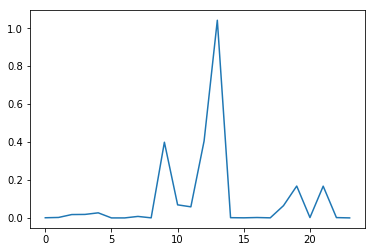

In [28]:
import matplotlib.pyplot as plt

ax = range(8340)
plt.plot(fitResult.test_loss)#, ax , fitResult1.test_loss)

In [32]:
fitResult_old = fitResult

## Image to digitized signal

In this section we train models to extruct the digitized signal from a rendered image containing it.  

### Imports and data loding

In [1]:
import torch
from models import Ecg12ImageToSignalNet
import transforms as tf
from ECG_rendered_to_matrix_DB_dataloader import *

root_dir = r'/home/noamkeidar/ML/db/'

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
ds = ECG_Rendered_to_matrix_Dataset(root_dir=root_dir)

In [3]:
num_train = 2 #35000
# for small set overfit experiment: 
#num_train = 1025
num_val = 1 # 1000
num_test = 2 #5000
batch_size = 1 # 16

# Training dataset & loader
ds_train = tf.SubsetDataset(ds, num_train)  #(train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Validation dataset & loader
ds_val = tf.SubsetDataset(ds, num_val, offset=num_train)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=2, pin_memory=True)

# Test dataset & loader
ds_test = tf.SubsetDataset(ds, num_test, offset=num_train + num_val)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, num_workers=2, pin_memory=True)

In [4]:
import time

start = time.time()
x, y = iter(dl_train).next()
end = time.time()
print(f'Time taken {end - start}')

Time taken 2.6414992809295654


In [5]:
batch_memory = x.element_size() * x.nelement() // 1024**2

print('Images of shape: ', x.shape)
print('Short leads of shape: ', y[0].size())
print('Long leads of shape: ', y[1].size())
print('Size of an input batch in the memory is: ~', batch_memory,'MB' )

Images of shape:  torch.Size([1, 675, 1450, 3])
Short leads of shape:  torch.Size([1, 12, 1250])
Long leads of shape:  torch.Size([1, 1, 5000])
Size of an input batch in the memory is: ~ 2 MB


### Model creation

In [28]:
in_h = x.shape[1]
in_w = x.shape[2]
in_channels = x.shape[3]
conv_hidden_channels = [8, 16, 32, 64, 128, 256]
conv_kernel_sizes = [5]*6

deconv_in_channels = 1024
deconv_hidden_channels_short = [512, 256, 128, 64, 32, 16]
deconv_kernel_lengths_short = [5]*6
deconv_hidden_channels_long = [512, 256, 128, 64, 32, 16, 8, 4]
deconv_kernel_lengths_long = [5]*8

conv_dropout = None
conv_stride = 2
conv_dilation = 1
conv_batch_norm = True

deconv_dropout_short = None
deconv_stride_short = 2
deconv_dilation_short = 1
deconv_batch_norm_short = True
deconv_out_kernel_short = 5
deconv_dropout_long = None
deconv_stride_long = 2
deconv_dilation_long = 1
deconv_batch_norm_long = True
deconv_out_kernel_long = 5

fc_hidden_dims=()

l_out_long = 5000
l_out_short = 1250
short_leads = 12
long_leads = 1

In [29]:
model = Ecg12ImageToSignalNet(in_channels, deconv_in_channels, in_h, in_w, conv_hidden_channels, conv_kernel_sizes,
                 deconv_hidden_channels_short, deconv_kernel_lengths_short,
                 deconv_hidden_channels_long, deconv_kernel_lengths_long,
                 conv_dropout, conv_stride, conv_dilation, conv_batch_norm,
                 deconv_dropout_short, deconv_stride_short, deconv_dilation_short,
                 deconv_batch_norm_short, deconv_out_kernel_short, deconv_dropout_long,
                 deconv_stride_long, deconv_dilation_long,
                 deconv_batch_norm_long, deconv_out_kernel_long, 
                 fc_hidden_dims, l_out_long, l_out_short, short_leads, long_leads).to(device)

print(model)

Ecg12ImageToSignalNet(
  (cnn2d): Ecg12ImageNet(
    (cnn): ConvNet2d(
      (cnn): Sequential(
        (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
        (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
        (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
        (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (14): ReLU()
        (15): Conv2d(

In [8]:
from models import NewNet

in_h = x.shape[1]
in_w = x.shape[2]
in_channels = x.shape[3]
conv_hidden_channels = [8, 16, 32, 64, 128, 256, 512]
conv_kernel_sizes = [3] + [5]*6

conv_dropout = None
conv_stride = 2
conv_dilation = 1
conv_batch_norm = True
fc_hidden_dims=()

l_out_long = 5000
l_out_short = 1250
short_leads = 12
long_leads = 1

model = NewNet(in_channels, in_h, in_w,
                 conv_hidden_channels, conv_kernel_sizes,
                 conv_dropout, conv_stride, conv_dilation, conv_batch_norm,
                 fc_hidden_dims, l_out_long, l_out_short, short_leads, long_leads).to(device)
print(model)

NewNet(
  (cnn2d): Ecg12ImageNet(
    (cnn): ConvNet2d(
      (cnn): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
        (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
        (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
        (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (14): ReLU()
        (15): Conv2d(128, 256, kerne

In [117]:
from models import BloodSugarSexMagik

in_h = x.shape[1]
in_w = x.shape[2]
in_channels = x.shape[3]

model = BloodSugarSexMagik(in_channels, in_h, in_w).to(device)

print(model)

BloodSugarSexMagik(
  (in_conv): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (reLu): ReLU()
  (attention_short): Conv2d(13, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bias_short): Conv2d(13, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention_long): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bias_long): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_short): Linear(in_features=11745000, out_features=12, bias=True)
  (fc_long): Linear(in_features=978750, out_features=1, bias=True)
)


In [118]:
x_try = x.transpose(1,2).transpose(1,3)
x_try = x_try.to(device, dtype=torch.float)

In [174]:
h = None
y_short = torch.Tensor().to(device)
y_long = torch.Tensor().to(device)

with torch.no_grad():
    for i in range(8):
        start = time.time()
        y_pred, h = model.forward(x_try,h, short_steps=20, long_steps=0, y_short=y_short, y_long=y_long)
        end = time.time()
        print(f'Time taken {end - start}')

torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
Time taken 0.012207984924316406
Time taken 0.012531757354736328
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.Size([1, 12, 675, 1450])
torch.

In [15]:
print(y_pred[0].shape)
print(y_pred[1].shape)

torch.Size([1, 12, 5])
torch.Size([1, 1, 5])


ValueError: x and y must have same first dimension, but have shapes (5000,) and (50000,)

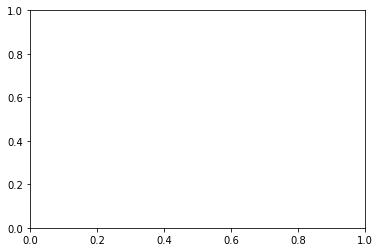

In [9]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0, 10, 1/500)
plt.plot(t, y_pred[1].flatten().tolist(), t, y[1].flatten().tolist())

print('Maybe some training will make the reconstruction better...')

### Let the game begin - Training

--- EPOCH 1/100 ---
test_batch (Avg. Loss 0.063, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
--- EPOCH 11/100 ---
test_batch (Avg. Loss 0.067, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]
--- EPOCH 21/100 ---
test_batch (Avg. Loss 0.069, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]
--- EPOCH 31/100 ---
test_batch (Avg. Loss 0.067, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]
--- EPOCH 41/100 ---
test_batch (Avg. Loss 0.068, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
--- EPOCH 51/100 ---
test_batch (Avg. Loss 0.073, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]
--- EPOCH 61/100 ---
test_batch (Avg. Loss 0.074, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
--- EPOCH 71/100 ---
test_batch (Avg. Loss 0.074, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
--- EPOCH 81/100 ---
test_batch (Avg. Loss 0.074, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]
--

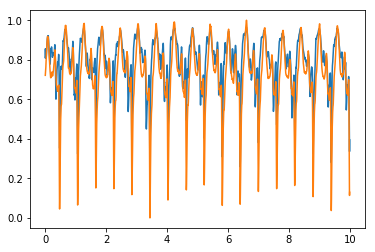

In [20]:
import torch.nn as nn
import torch.optim as optim
from training import EcgImageToDigitizedTrainer
from torch.nn import functional as F

torch.manual_seed(42)

lr = 0.01
num_epochs = 100

def maxLoss(y_tag, y):
    return torch.mean(torch.max(torch.abs(y_tag-y), dim=2)[0])

def fancyLoss(y_tag, y):
    loss = F.mse_loss(y, y_tag)
    dy = y[:,:, 1:] - y[:,:, :-1]
    dy_tag = y_tag[:, :, 1:] - y_tag[:, :, :-1]
    diff_loss = F.mse_loss(dy*500,dy_tag*500)
    max_loss = torch.mean(torch.max(torch.abs(y_tag-y), dim=2)[0])
    loss = loss + diff_loss + max_loss
    return loss

loss_fn = nn.MSELoss()
#loss_fn = maxLoss
#loss_fn = fancyLoss

optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = EcgImageToDigitizedTrainer(model, loss_fn, optimizer, device)

fitResult = trainer.fit(dl_train, dl_val, num_epochs, #checkpoints=r'checkpoints/Ecg12LeadImageNet',
                        early_stopping=1000, print_every=10)

x, y = iter(dl_train).next()
x_try = x.transpose(1,2).transpose(1,3)
x_try = x_try.to(device, dtype=torch.float)
y_pred = model(x_try)
t = np.arange(0, 10, 1/500)
plt.plot(t, y_pred[1][0].flatten().tolist(), t, y[1][0].flatten().tolist())

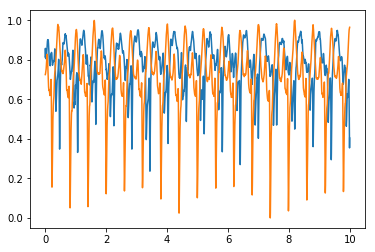

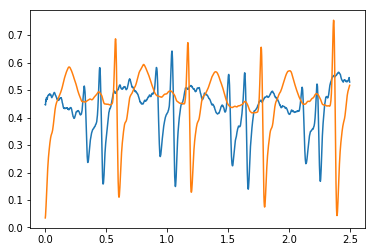

In [29]:
import torch.nn as nn

s = nn.Sigmoid()

it = iter(dl_test)
x, y = it.next()
x_try = x.transpose(1,2).transpose(1,3)
x_try = x_try.to(device, dtype=torch.float)
with torch.no_grad():
    y_pred = model(x_try)
t = np.arange(0, 10, 1/500)
#plt.plot(t, y_pred[1][0].flatten().tolist(), t, y[1][0].flatten().tolist())


plt.figure()
x, y = it.next()
x_try = x.transpose(1,2).transpose(1,3)
x_try = x_try.to(device, dtype=torch.float)
with torch.no_grad():
    y_pred = model(x_try)
t1 = np.arange(0, 2.5, 1/500)
t = np.arange(0, 10, 1/500)

plt.plot(t, y_pred[1][0].flatten().tolist(), t, y[1][0].flatten().tolist())

plt.figure()
l = 9
plt.plot(t1, y_pred[0][0][l].flatten().tolist(), t1, y[0][0][l].flatten().tolist())

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fitResult.train_loss)

In [13]:
x.device

device(type='cpu')

In [164]:
4/4

1.0